In [1]:
import platform
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_validate, learning_curve, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    path = '/Library/Fonts/Arial Unicode.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~~~~~')

print(f"해당 pc의 운영 체제는 {platform.system()}이며 {font_name}로 설정되었습니다")  

해당 pc의 운영 체제는 Darwin이며 Arial Unicode MS로 설정되었습니다


In [2]:
# preprocessing
train = pd.read_csv('dataset/train.csv')
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수']
error_code = ['C2085', 'C1397', 'C2431','C1649','C1036','C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'] 
new_train = train[~train['단지코드'].isin(error_code)]
new_train['임대보증금'] = new_train['임대보증금'].replace('-', np.nan).astype(float)
new_train['임대료'] = new_train['임대료'].replace('-', np.nan).astype(float)
new_train['전용면적'] = new_train['전용면적']//5*5
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   공급유형      2869 non-null   object 
 5   전용면적      2869 non-null   float64
 6   전용면적별세대수  2869 non-null   int64  
 7   공가수       2869 non-null   float64
 8   신분        2869 non-null   object 
 9   임대보증금     2288 non-null   float64
 10  임대료       2285 non-null   float64
 11  지하철       2662 non-null   float64
 12  버스        2869 non-null   float64
 13  단지내주차면수   2869 non-null   float64
 14  등록차량수     2869 non-null   float64
dtypes: float64(8), int64(2), object(5)
memory usage: 358.6+ KB


In [3]:
# nan value
new_train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
신분            0
임대보증금       581
임대료         584
지하철         207
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

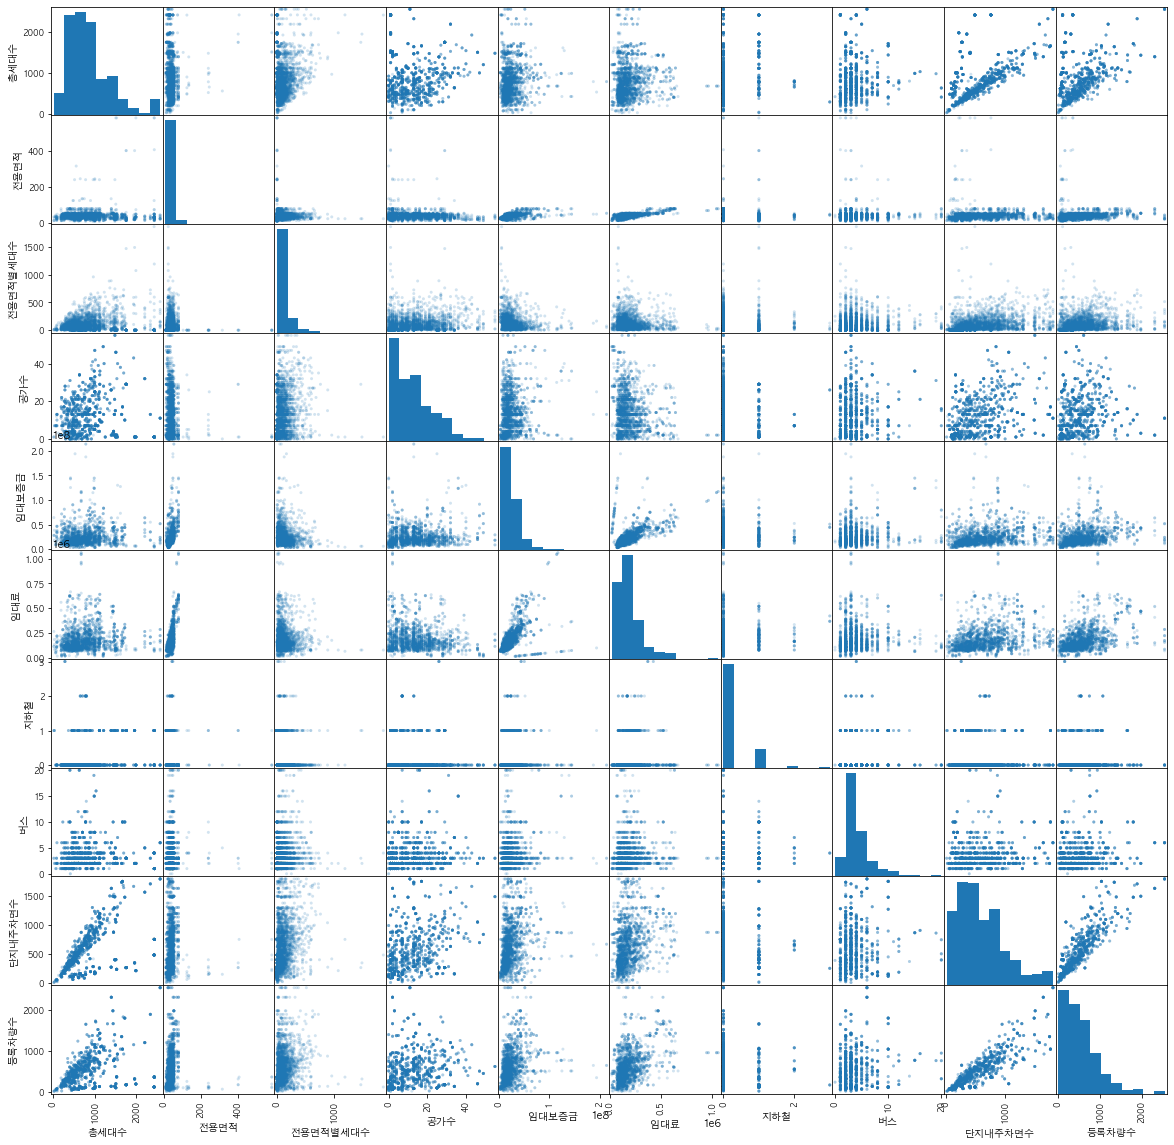

In [4]:
# check feature distribution
pd.plotting.scatter_matrix(new_train, alpha=0.2, figsize=(20, 20))
# plt.show();
plt.savefig('image1.png', facecolor='white')

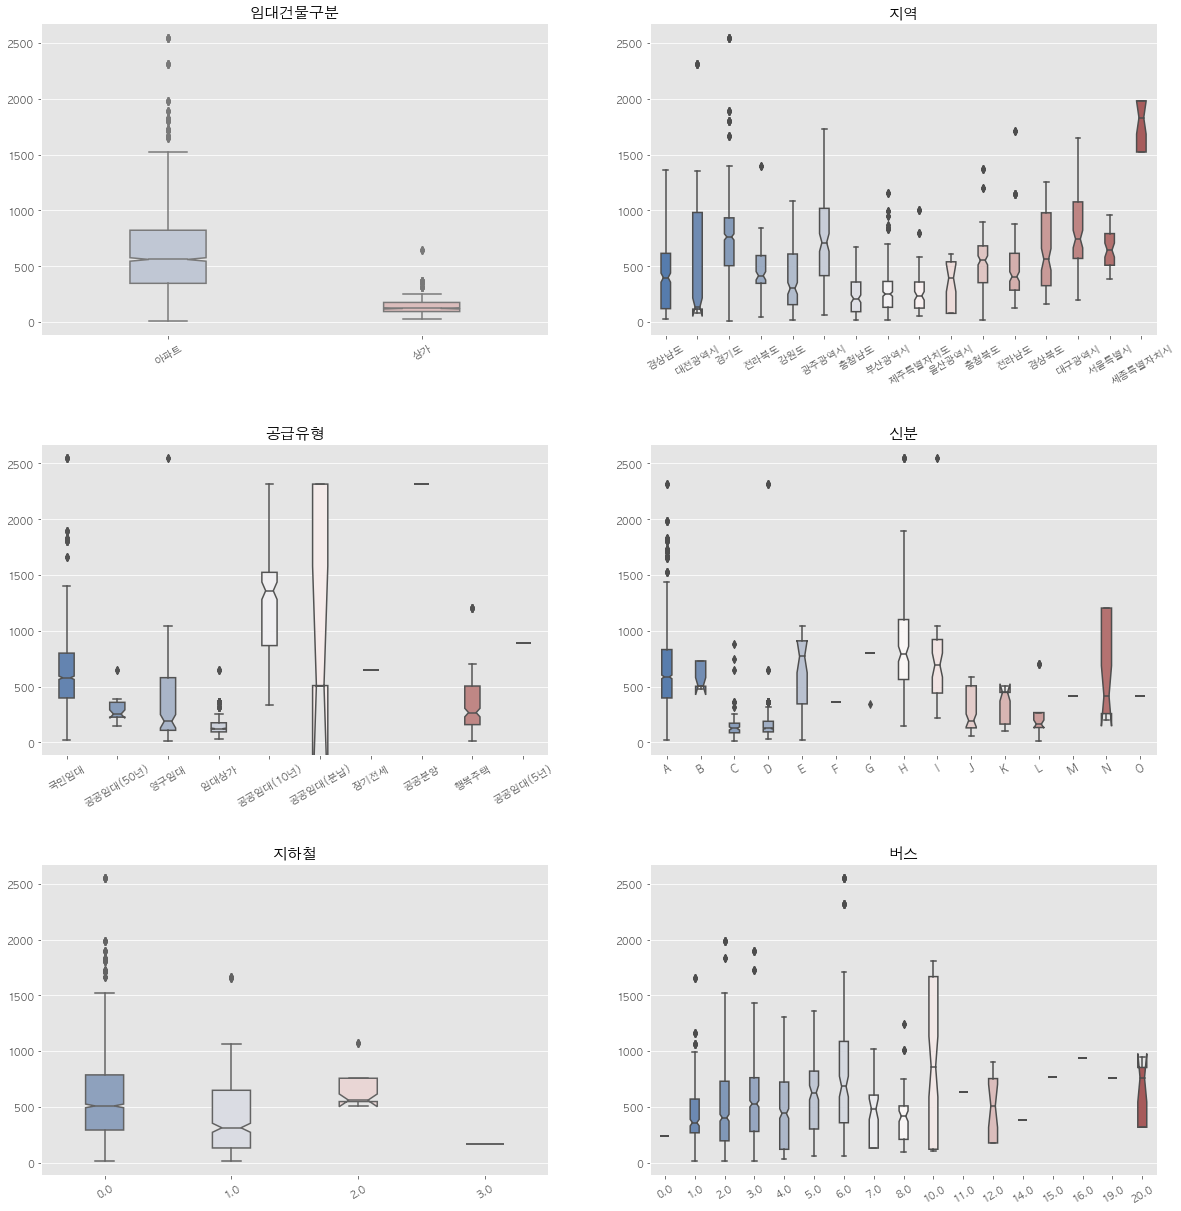

In [6]:
# check feature distribution by boxplot
var_list = ['임대건물구분', '지역', '공급유형', '신분', '지하철', '버스']
data = new_train

plt.style.use('ggplot')
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

column_idx = 0
for i in range(3):
    for j in range(2):
        sns.boxplot(x = data[var_list[column_idx]], y = data['등록차량수'], notch = True, width = 0.3, palette="vlag", ax = ax[i][j]).set_title(var_list[column_idx], fontsize = 15)
        ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=30)
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        column_idx += 1
# plt.show();
plt.savefig('image2.png', facecolor='white')

In [ ]:
# def plot_box(x, y, hue=None):
#     plt.figure(figsize=(20, 20))
#     sns.boxplot(x, y, hue, palette="cubehelix")
#     plt.show();

In [ ]:
# plot_box(new_train['지역'], new_train['임대보증금'])
# plot_box(new_train['신분'], new_train['임대보증금'])

In [ ]:
# def plot_scatter(x, y, hue=None):
#     plt.figure(figsize=(20, 20))
#     sns.scatterplot(x, y, hue, palette="cubehelix")
#     plt.show();

In [ ]:
# plot_scatter(new_train['임대보증금'], new_train['임대료'], new_train['지역'])

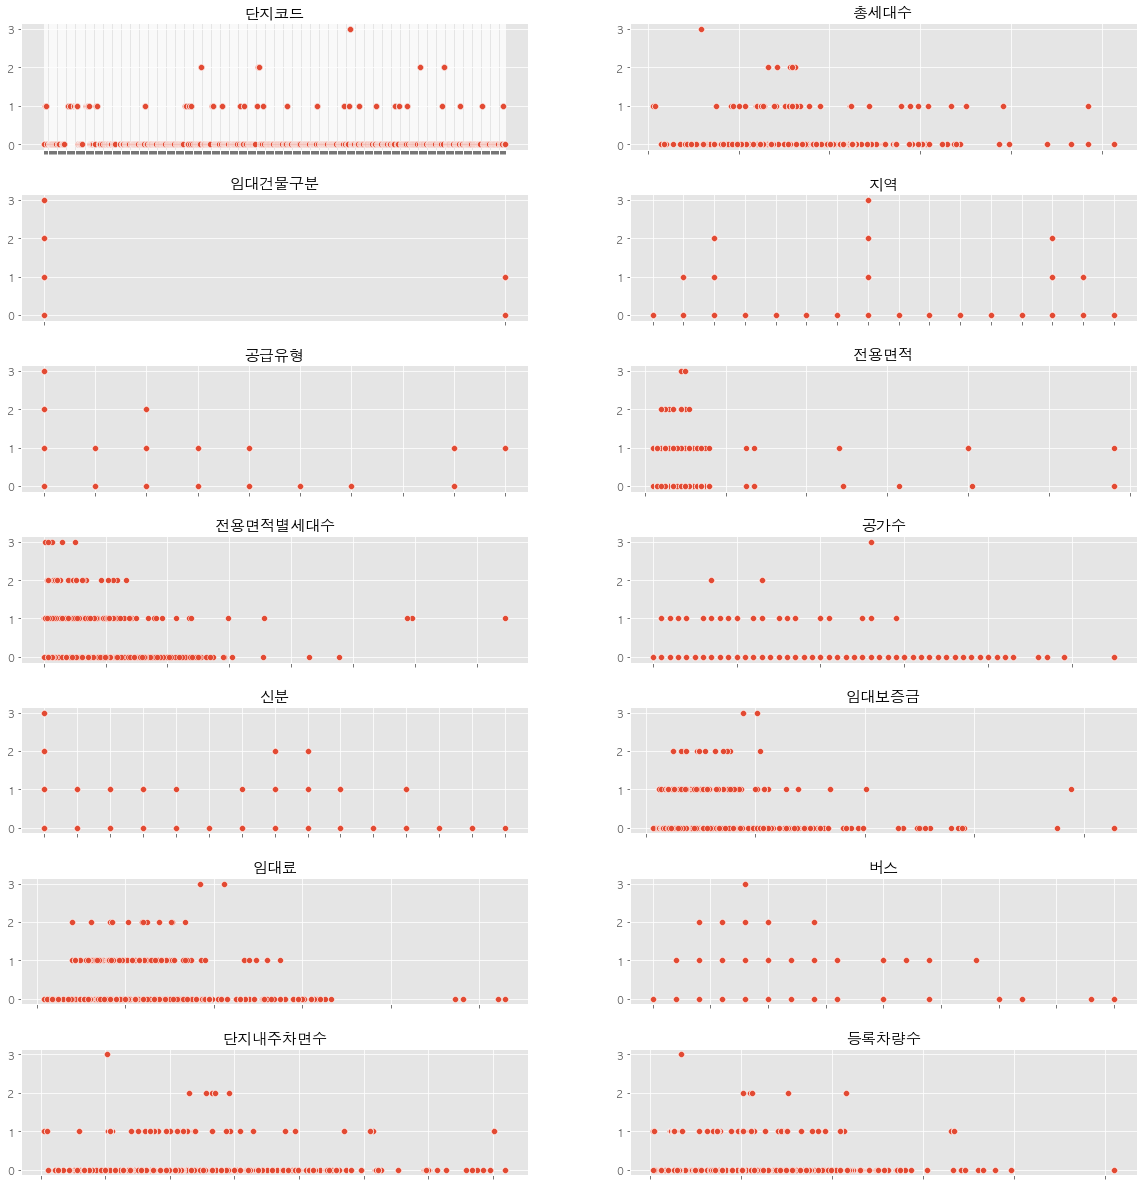

In [7]:
# subway column fill nan value 
# check feature distribution
var_list = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
       '임대보증금', '임대료', '버스', '단지내주차면수', '등록차량수']
data = new_train

plt.style.use('ggplot')
fig, ax = plt.subplots(7, 2, figsize=(20, 20))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

column_idx = 0
for i in range(7):
    for j in range(2):
        sns.scatterplot(x = data[var_list[column_idx]], y = data['지하철'], ax = ax[i][j]).set_title(var_list[column_idx], fontsize = 15)
        ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=30)
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        column_idx += 1
# plt.show();
plt.savefig('image3.png', facecolor='white')

In [8]:
# fill nan value by area mean
new_train[new_train['지하철'].isna()==True]['지역'].unique()

array(['충청남도', '대전광역시'], dtype=object)

In [9]:
temp = new_train.copy()
region_list = ['충청남도', '대전광역시']

for idx, i  in enumerate(region_list):
    new_train.loc[(new_train['지역'] == i) & (new_train['지하철'].isna()==True), '지하철'] = temp[temp['지역'] == i]['지하철'].mean()
        
new_train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
신분            0
임대보증금       581
임대료         584
지하철           0
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [10]:
# fill rent deposit and rent nan value by regression 
def regression(model, X, y):
    model.fit(X, y)
    r2 = model.score(X, y)
    y_hat = model.predict(X)
    rmse = np.sqrt(((y_hat - y) ** 2).mean())
    print ("r2 socre :", r2, "RMSE :", rmse)

In [11]:
def fill_column(model, X, y, X_re, column):
    model.fit(X, y)
    predict = model.predict(X_re)
    data = X_re.copy()
    data[column] = predict
    temp[column].loc[data.index] = data[column]

In [12]:
# fill rent deposit and rent nan value by regression 
temp = new_train.copy()

# categorical feature labeling
local_map = {}
var_list = ['단지코드', '임대건물구분', '지역', '공급유형', '신분']
for idx, var in enumerate(var_list):
    for i, loc in enumerate(temp[var].unique()):
        local_map[loc] = i
        
    temp[var] = temp[var].map(local_map)

In [13]:
# apt rent deposit
apt_deposit_not_null = temp[(temp['임대건물구분'] == 0) & (temp['임대보증금'].isna() == False)]
apt_deposit_null = temp[(temp['임대건물구분'] == 0) & (temp['임대보증금'].isna() == True)]

X = apt_deposit_not_null.drop(['임대건물구분','임대보증금','임대료', '등록차량수'], axis=1)
y = apt_deposit_not_null['임대보증금']

In [14]:
lr = LinearRegression()
regression(lr, X, y)

r2 socre : 0.469571269027485 RMSE : 14240904.729933232


In [15]:
X_re = apt_deposit_null.drop(['임대건물구분','임대보증금','임대료', '등록차량수'], 1)
fill_column(lr, X, y, X_re, column = '임대보증금')

In [16]:
# apt rent
apt_rent_not_null = temp[(temp['임대건물구분'] == 0) & (temp['임대료'].isna() == False)]
apt_rent_null = temp[(temp['임대건물구분'] == 0) & (temp['임대료'].isna() == True)]

X = apt_rent_not_null.drop(['임대건물구분','임대보증금','임대료', '등록차량수'], axis=1)
y = apt_rent_not_null['임대료']

In [17]:
regression(lr, X, y)

r2 socre : 0.6908740814964134 RMSE : 69763.20055042396


In [18]:
X_re = apt_rent_null.drop(['임대건물구분','임대보증금','임대료', '등록차량수'], 1)
fill_column(lr, X, y, X_re, column = '임대료')

In [19]:
temp.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
신분            0
임대보증금       562
임대료         562
지하철           0
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [20]:
# retail store (https://www.data.go.kr/data/15069062/fileData.do)
# preprocessing
rent_retail = pd.read_csv("dataset/rent_retail.csv", encoding = "cp949")
rent_retail['지역'] = ""
area_dic = {
            "진해" : "경상남도",
            "진주" : "경상남도",
            "통영" : "경상남도",
            "마산" : "경상남도",
            "김해" : "경상남도",
            "부산" : "경상남도",
            "대전" : "대전광역시",
            "의정부" : "경기도",
            "인천" : "경기도", 
            "분당" : "경기도", 
            "광명" : "경기도", 
            "수원" : "경기도", 
            "산본" : "경기도", 
            "안산" : "경기도", 
            "부천" : "경기도",
            "남원" : "전라북도", 
            "익산" : "전라북도",  
            "군산" : "전라북도",
            "전주" : "전라북도",
            "원주" : "강원도",
            "광주" : "광주광역시",
            "보령" : "충청남도", 
            "공주" : "충청남도", 
            "천안" : "충청남도", 
            "부산" : "부산광역시",
            "서귀포" : "제주특별자치도",
            "울산" : "울산광역시",
            "청주" : "충청북도", 
            "충주" : "충청북도", 
            "순천" : "전라남도",
            "여수" : "전라남도", 
            "목포" : "전라남도", 
            "안동" : "경상북도", 
            "포항" : "경상북도", 
            "영천" : "경상북도", 
            "영주" : "경상북도", 
            "구미" : "경상북도",
            "대구" : "대구광역시",
            "서울" : "서울특별시"
            }

for key, val in area_dic.items():
    rent_retail['지역'].loc[rent_retail["관리소명"].str.contains(key)] = val
    
rent_retail['지역'].isnull().sum()

0

In [21]:
rent_retail['임대보증금'] = rent_retail[' 계약금 '] + rent_retail[' 잔금 '] 
new_rent_retail = rent_retail[['전용면적', '임대보증금', ' 월임대료 ', '지역']]
new_rent_retail['전용면적'] = new_rent_retail['전용면적']//5*5

var_dic = {
            '경상남도': 0,
            '대전광역시': 1,
            '경기도': 2,
            '전라북도': 3,
            '강원도': 4,
            '광주광역시': 5,
            '충청남도': 6,
            '부산광역시': 7,
            '제주특별자치도': 8,
            '울산광역시': 9,
            '충청북도': 10,
            '전라남도': 11,
            '경상북도': 12,
            '대구광역시': 13,
            '서울특별시': 14,
            '세종특별자치시': 15
            }

for key, val in var_dic.items():
    new_rent_retail['지역'].loc[new_rent_retail['지역'].str.contains(key, na=False)] = val

In [22]:
# regrssion rent deposit
X = new_rent_retail.drop(['임대보증금', " 월임대료 "], 1)
y = new_rent_retail['임대보증금']

In [23]:
regression(lr, X, y)

r2 socre : 0.6370973165005848 RMSE : 5990304.499549153


In [24]:
# fill rent deposit nan value by prediction
retail_deposit_null = temp[temp['임대보증금'].isna() == True]
retail_deposit_null = retail_deposit_null[['전용면적', '지역']]

fill_column(lr, X, y, retail_deposit_null, '임대보증금')

In [25]:
# regrssion rent
X = new_rent_retail.drop(['임대보증금', " 월임대료 "], 1)
y = new_rent_retail[' 월임대료 ']

In [26]:
regression(lr, X, y)

r2 socre : 0.6877621402438863 RMSE : 165872.95302231706


In [27]:
# fill rent nan value by prediction
retail_rent_null = temp[temp['임대료'].isna() == True]
retail_rent_null = retail_rent_null[['전용면적', '지역']]

fill_column(lr, X, y, retail_deposit_null, '임대료')

In [28]:
# make final data
final = temp

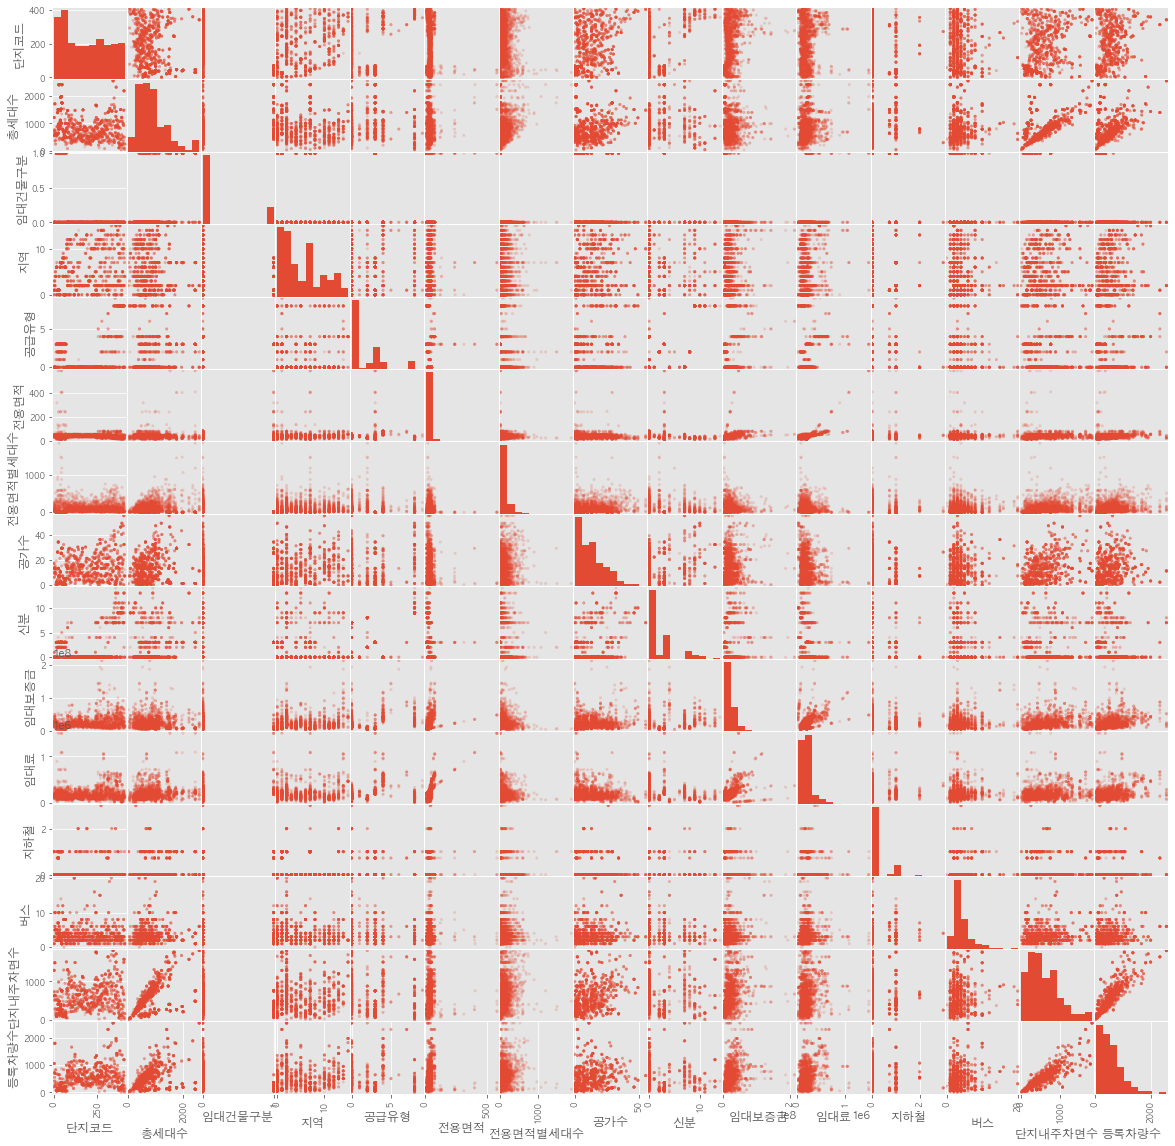

In [29]:
# feature distribution
pd.plotting.scatter_matrix(final, alpha=0.2, figsize=(20, 20))
# plt.show();
plt.savefig('image4.png', facecolor='white')

In [30]:
# robust scaling
X = final.drop(['등록차량수'], 1)
y = final['등록차량수']

In [31]:
robust = RobustScaler()
robust.fit(X)
features = X.columns
data = robust.transform(X)
scaled_X = pd.DataFrame(columns=features, data=data)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=42)

In [33]:
# build
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
ridge = Ridge()
lasso = Lasso()
lr =  LinearRegression()

cv = KFold(5, shuffle=True, random_state=42)
regressor = [dt, rf, ridge, lasso, lr]
regressor_name = ['DecisionTreeRegression', 'RandomForestRegression', 'Ridge', 'Lasso', 'LinearRegression']

In [34]:
def model_check(X, y, regressor, cv):
    model_table = pd.DataFrame()
    idx = 0
    for reg in regressor:
        model_table.loc[idx, 'Name'] = regressor_name[idx]
        
        cv_results = cross_validate(dt, 
                                    X, 
                                    y, 
                                    scoring=('r2','neg_mean_squared_error',"neg_mean_absolute_error"), 
                                    cv=cv)
        model_table.loc[idx, 'Test r2'] = cv_results['test_r2'].mean()
        model_table.loc[idx, 'Test RMSE'] = cv_results['test_neg_mean_squared_error'].mean()
        model_table.loc[idx, 'Test MAE'] = cv_results['test_neg_mean_absolute_error'].mean()
        
        idx += 1
    return model_table

In [35]:
# A function for learning curve plot
def plot_learning_curve(regressor,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    fig, axes = plt.subplots(5, 1, figsize=(20, 25))
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
#     axes = axes.flatten()
    
    for ax, reg in zip(axes, regressor):

        ax.set_title(f'{reg.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(reg, X, y, cv=cv, return_times=True, scoring='neg_mean_squared_error', random_state=42)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='b')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='b',
                label='Cross-validation score')
        ax.legend(loc='best')
#     plt.show();

In [36]:
def feature_importance(regressor):
    fig, axes = plt.subplots(2, 1, figsize=(20,15), constrained_layout=True)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    fig.suptitle("Feature Importances", fontsize=30)
    for ax, reg in zip(axes, regressor):
        reg.fit(X,y)
        feature_imp = reg.feature_importances_
        importances = pd.DataFrame()
        importances['variables'] = X.columns
        importances['feature'] = feature_imp
        importances = importances.sort_values(by=['feature'], ascending=False)

        sns.barplot(x='variables', y='feature', data=importances, palette="vlag", ax=ax)
        ax.set_title(f'{reg.__class__.__name__}')
#     plt.show();

In [37]:
def coefficient(regressor):
    fig, axes = plt.subplots(3, 1, figsize=(20,15), constrained_layout=True)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    fig.suptitle("Feature Coefficient", fontsize=30)
    for ax, reg in zip(axes, regressor):
        reg.fit(X, y)
        coef = pd.Series(reg.coef_, index=X.columns)
        
        sns.barplot(x=coef.values, y=coef.index, palette="vlag", ax=ax)
        ax.set_title(f'{reg.__class__.__name__}')
#     plt.show();

In [38]:
model_check(X, y, regressor, cv)

,Name,Test r2,Test RMSE,Test MAE
0,DecisionTreeRegression,0.987417,-2364.169031,-6.566603
1,RandomForestRegression,0.988614,-2131.752109,-6.964140
2,Ridge,0.988137,-2227.900550,-6.375233
3,Lasso,0.987475,-2343.245872,-6.461541
4,LinearRegression,0.988214,-2204.831631,-6.601091


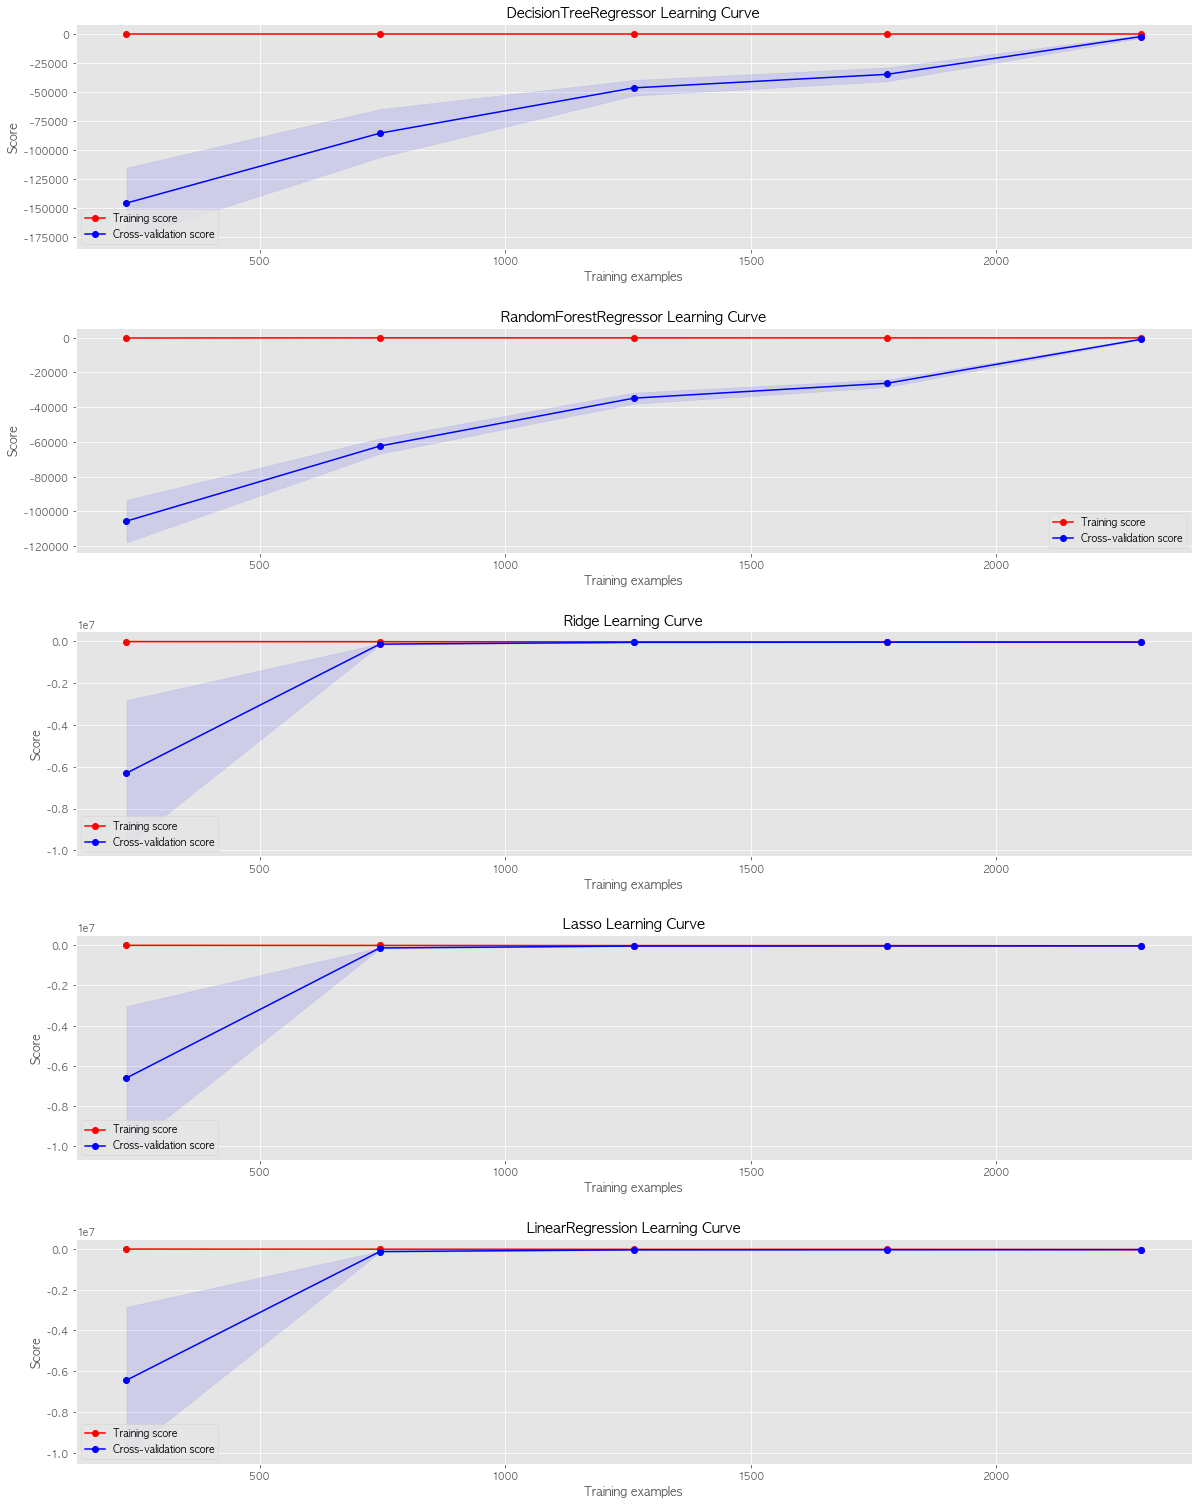

In [39]:
plot_learning_curve(regressor, X, y, ylim=None, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
plt.savefig('image5.png', facecolor='white')

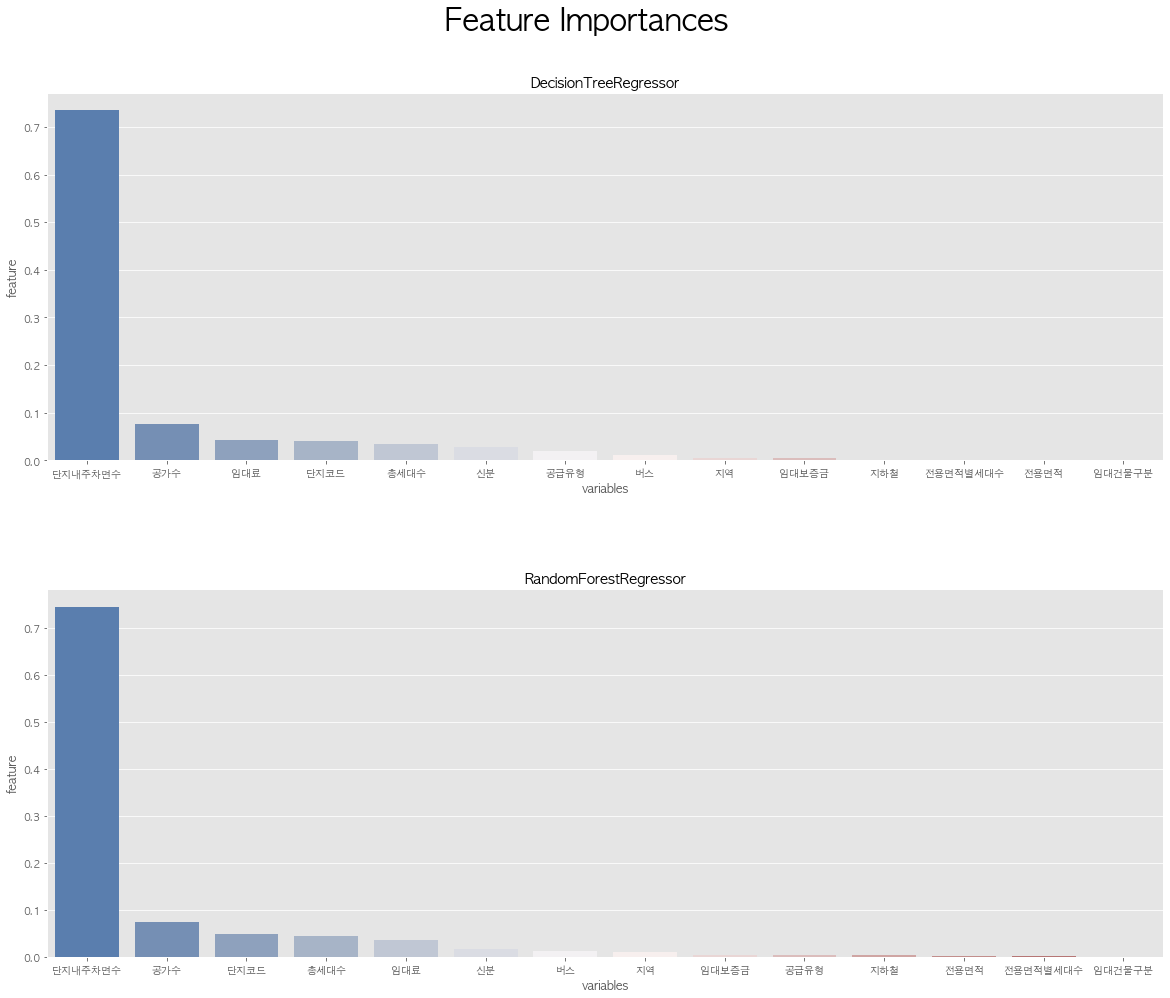

In [40]:
regressor_re = [dt, rf]
feature_importance(regressor_re)
plt.savefig('image6.png', facecolor='white')

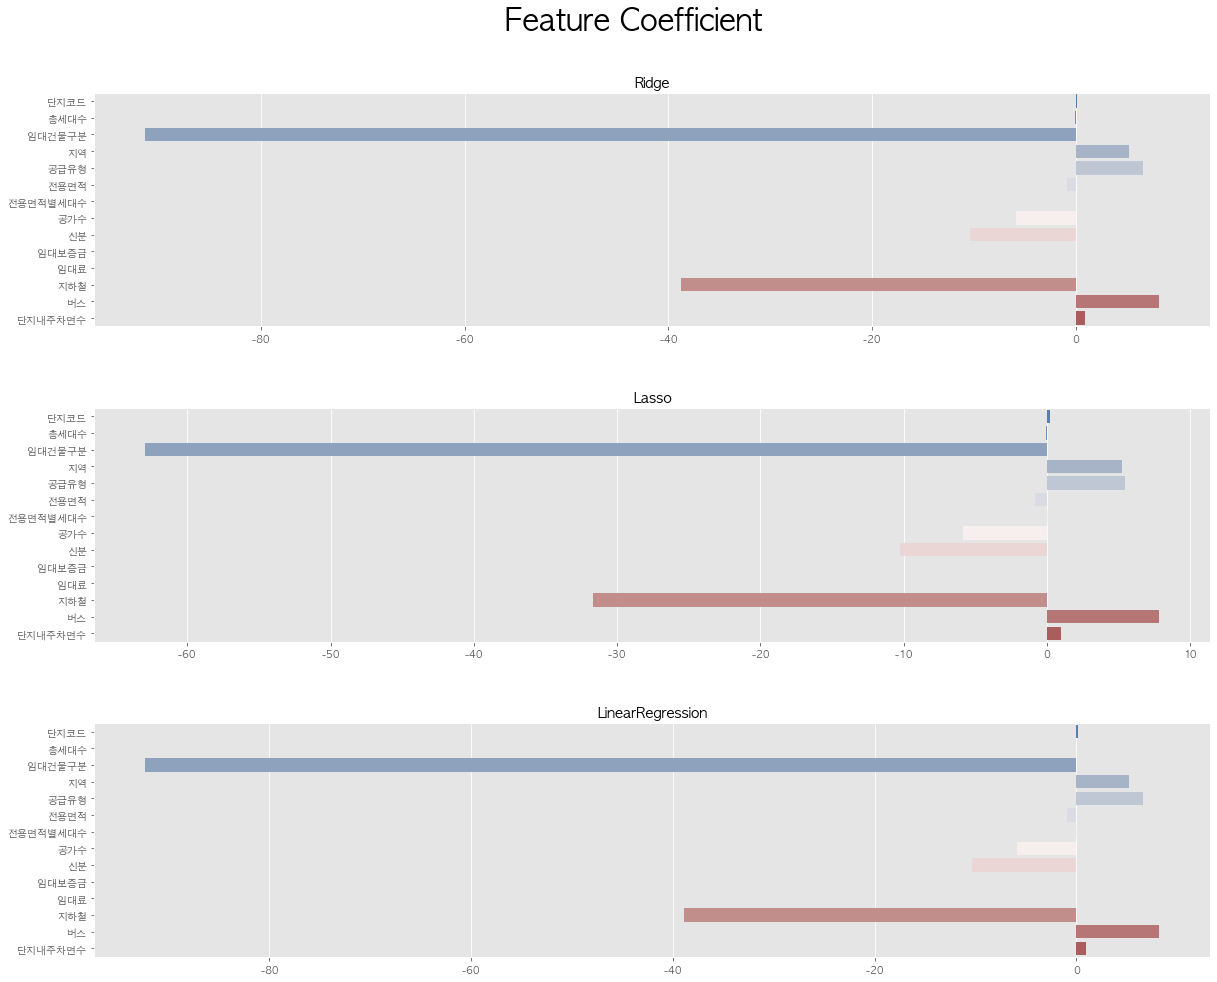

In [41]:
regressor_coef = [ridge, lasso, lr]
coefficient(regressor_coef)
plt.savefig('image7.png', facecolor='white')